<a href="https://colab.research.google.com/github/Erickrus/llm/blob/main/lightrag_with_ollama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightRAG with Ollama

## 🚀 LightRAG: Simple and Fast Retrieval-Augmented Generation

![请添加图片描述](https://i-blog.csdnimg.cn/direct/567139f1a36e4564abc63ce5c12b6271.jpeg)


<img src="https://camo.githubusercontent.com/054a656498dc5e6890e4ec2ec7e0444fa754051d652642e1bf8ad529762c7012/68747470733a2f2f692d626c6f672e6373646e696d672e636e2f6469726563742f62326161663633343135316234373036383932363933666662343364393039332e706e67" width=1000px />

The Best, Ultra-Fast and Low-Cost GraphRAG: LightRAG

tutorial: https://www.youtube.com/watch?v=I5czVNgOezE

intro video: https://youtu.be/oageL-1I0GE

paper: https://arxiv.org/pdf/2410.05779

github: https://github.com/HKUDS/LightRAG

**ABSTRACT**

Retrieval-Augmented Generation (RAG) systems enhance large language models (LLMs) by integrating external knowledge sources, enabling more accurate and contextually relevant responses tailored to user needs. However, existing RAG systems have significant limitations, including reliance on flat data representations and inadequate contextual awareness, which can lead to fragmented answers that fail to capture complex inter-dependencies. To address these challenges, we propose LightRAG, which incorporates graph structures into text indexing and retrieval processes. This innovative framework employs a dual-level retrieval system that enhances comprehensive information retrieval from both low-level and high-level knowledge discovery. Additionally, the integration of graph structures with vector representations facilitates efficient retrieval of related entities and their relationships, significantly improving response times while maintaining contextual relevance. This capability is further enhanced by an incremental update algorithm that ensures the timely integration of new data, allowing the system to remain effective and responsive in rapidly changing data environments. Extensive experimental validation demonstrates considerable improvements in retrieval accuracy and efficiency compared to existing approaches. We have made our LightRAG open-source and available at the link: https://github.com/HKUDS/LightRAG.

3 THE LIGHTRAG ARCHITECTURE

3.1 GRAPH-BASED TEXT INDEXING

• Extracting Entities and Relationships

to identify entities (nodes) and their relationships (edges) within the text data.

• LLM Profiling for Key-Value Pair Generation

Each index key is a word or short phrase that enables efficient retrieval, while the corresponding value is a text paragraph summarizing relevant snippets from external data to aid in text generation

• Deduplication to Optimize Graph Operations

deduplication



In [1]:
!nvidia-smi

Thu Oct 24 01:21:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#@markdown FabUtil
import os
import json

import tarfile
from zipfile import ZipFile

# import google util
try:
  from google.colab import drive
  from google.colab._system_commands import _shell_line_magic as shell_line_magic
except:
  shell_line_magic = os.system


class FabUtil:
  def cust_code(self, codeFilename, content):
    self._ensure_dir(codeFilename)
    with open(codeFilename, 'w') as f:
      f.write(content)

  def fabricate(self, fabs):
    # accept both filename and fabs object
    if type(fabs) == str:
      with open(fabs, "r") as f:
        fabs = json.loads(fabs)
    elif type(fabs) == dict:
      pass

    for i in range(len(fabs["fabs"])):
      fab = fabs["fabs"][i]
      if "cmd" in fab:
        print("%s" % fab["cmd"])
        shell_line_magic("%s" % fab["cmd"])
        #os.system("%s" % fab["cmd"])
        continue

      if "patches" in fab:
        self._patch(fab["srcFilename"], fab["patches"])
        continue

      entryFilename = ""
      srcFilename = fab["srcFilename"]
      if srcFilename.find("::") > 0:
        srcFilename, entryFilename = srcFilename.split("::")
      tgtFilename = fab["tgtFilename"]
      srcFilename = os.path.join(fabs["baseDir"], srcFilename)

      if entryFilename != "":
        self._process_zip_file(srcFilename, entryFilename, tgtFilename)
      else:
        self._ensure_dir(tgtFilename)
        os.system("cp %s %s" % (srcFilename, tgtFilename))
        print("fabricated %s ==> %s" % (srcFilename, tgtFilename))

  def _patch(self, filename, patches):
    changed = False
    with open(filename, 'r') as f:
      lines = f.read().split('\n')
    for patchItem in patches:
      lineNum = patchItem['lineNum']
      fromText = patchItem['fromText']
      toText = patchItem['toText']
      if lines[lineNum-1] == fromText:
        lines[lineNum-1] = toText
        changed = True
    if changed:
      with open(filename, 'w') as f:
        f.write('\n'.join(lines))

  def _ensure_dir(self, tgtFilename):
    dirName = os.path.dirname(tgtFilename)
    if not os.path.exists(dirName):
      os.system("mkdir -p %s " % dirName)

  def _process_zip_file(self, srcFilename, entryFilename, tgtFilename):
    try:
      if srcFilename.lower().find(".tar") > 0 or srcFilename.lower().find(".tgz") > 0:
        fileOp = 'r'
        if srcFilename.lower().endswith('.tar.gz') or srcFilename.lower().endswith('.tgz'): # gzip
            fileOp = 'r:gz'
        elif srcFilename.lower().endswith('.tar.bz2'): # bzip2
            fileOp = 'r:bz2'
        elif srcFilename.lower().endswith('.tar.xz'): # lzma
            fileOp = 'r:xz'
        with tarfile.open(srcFilename, fileOp) as tar:
          self._ensure_dir(tgtFilename)
          with open(tgtFilename, "wb") as f:
            f.write(tar.extractfile(entryFilename).read())
        print("fabricated %s::%s ==> %s" % (srcFilename, entryFilename, tgtFilename))
        return
      if srcFilename.lower().find(".zip") >0:
        with ZipFile(srcFilename, 'r') as z:
          self._ensure_dir(tgtFilename)
          with open(tgtFilename, "wb") as f:
            f.write(z.read(entryFilename))
        print("fabricated %s::%s ==> %s" % (srcFilename, entryFilename, tgtFilename))
        return
    except:
      print("failed %s::%s ==> %s" % (srcFilename, entryFilename, tgtFilename))
      return
    print("not found %s::%s ==> %s" % (srcFilename, entryFilename, tgtFilename))

fb = FabUtil()




## Install Ollama

In [3]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [4]:
#@title select model
import os
MODEL_NAME = "llama3.1:8b" #@param ["wangshenzhi/llama3-8b-chinese-chat-ollama-q8", "phi3", "llama3.1:8b", "llava", "gemma2"]
os.environ["MODEL_NAME"] = MODEL_NAME

In [5]:
!pip3 install -q ollama
# ollama==0.3.0
#!pip3 install -q --upgrade ollamax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00


In [6]:
#@title start ollama as a service
!nohup ollama serve &
#!echo 'hello' |ollama run {MODEL_NAME}

nohup: appending output to 'nohup.out'


In [7]:
!ps -ef | grep ollama

root         626       1  0 01:22 ?        00:00:00 ollama serve
root         636     275  0 01:22 ?        00:00:00 /bin/bash -c ps -ef | grep ollama
root         638     636  0 01:22 ?        00:00:00 grep ollama


In [ ]:
#@title pull models
#@markdown llama3.1:8b

#@markdown nomic-embed-text:v1.5
!ollama pull llama3.1:8b
#!ollama pull gemma2
!ollama pull nomic-embed-text:v1.5

In [9]:
!ollama list

NAME                     ID              SIZE      MODIFIED               
nomic-embed-text:v1.5    0a109f422b47    274 MB    Less than a second ago    
llama3.1:8b              42182419e950    4.7 GB    11 seconds ago            


## Install

In [10]:
#@markdown * Install from source (Recommend)
#@markdown
#@markdown ```bash
#@markdown cd LightRAG
#@markdown pip install -e .
#@markdown ```
%cd /content
!git clone https://github.com/HKUDS/LightRAG
#!cd LightRAG && pip install -e .
!pip install -q lightrag-hku
#@markdown * Install from PyPI
#@markdown ```bash
#@markdown pip install lightrag-hku
#@markdown ```

/content
Cloning into 'LightRAG'...
remote: Enumerating objects: 500, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 500 (delta 123), reused 102 (delta 93), pack-reused 319 (from 1)
Receiving objects: 100% (500/500), 194.10 KiB | 8.82 MiB/s, done.
Resolving deltas: 100% (290/290), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━



## Quick Start


In [11]:
#@markdown * [Video demo](https://www.youtube.com/watch?v=g21royNJ4fw) of running LightRAG locally.
#@markdown * All the code can be found in the `examples`.
#@markdown * Set OpenAI API key in environment if using OpenAI models: `export OPENAI_API_KEY="sk-...".`
#@markdown * Download the demo text "A Christmas Carol by Charles Dickens":
#@markdown ```bash
#@markdown curl https://raw.githubusercontent.com/gusye1234/nano-graphrag/main/tests/mock_data.txt > ./book.txt
#@markdown ```
%cd /content/LightRAG
#!curl https://raw.githubusercontent.com/gusye1234/nano-graphrag/main/tests/mock_data.txt > ./book.txt

import os
from bs4 import BeautifulSoup
from urllib.request import urlopen

os.makedirs("/content/LightRAG", exist_ok=True)

url = "https://raw.githubusercontent.com/gusye1234/nano-graphrag/main/tests/mock_data.txt"
lines = urlopen(url).read().decode('utf-8')

with open("/content/LightRAG/book.txt", "w") as f:
    i = 0
    for line in lines.split("\n"):
        if line.strip() == "":
            continue
        f.write(line.strip()+"\n")
        i += 1
        if i > 500:
            break
print("trim book.txt to 500 lines")






/content/LightRAG
trim book.txt to 500 lines


Use the below Python snippet (in a script) to initialize LightRAG and perform queries:

```python
import os
from lightrag import LightRAG, QueryParam
from lightrag.llm import gpt_4o_mini_complete, gpt_4o_complete

#########
# Uncomment the below two lines if running in a jupyter notebook to handle the async nature of rag.insert()
# import nest_asyncio
# nest_asyncio.apply()
#########

WORKING_DIR = "./dickens"


if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=gpt_4o_mini_complete  # Use gpt_4o_mini_complete LLM model
    # llm_model_func=gpt_4o_complete  # Optionally, use a stronger model
)

with open("./book.txt") as f:
    rag.insert(f.read())

# Perform naive search
print(rag.query("What are the top themes in this story?", param=QueryParam(mode="naive")))

# Perform local search
print(rag.query("What are the top themes in this story?", param=QueryParam(mode="local")))

# Perform global search
print(rag.query("What are the top themes in this story?", param=QueryParam(mode="global")))

# Perform hybrid search
print(rag.query("What are the top themes in this story?", param=QueryParam(mode="hybrid")))
```

<details>
<summary> Using Open AI-like APIs </summary>

* LightRAG also supports Open AI-like chat/embeddings APIs:
```python
async def llm_model_func(
    prompt, system_prompt=None, history_messages=[], **kwargs
) -> str:
    return await openai_complete_if_cache(
        "solar-mini",
        prompt,
        system_prompt=system_prompt,
        history_messages=history_messages,
        api_key=os.getenv("UPSTAGE_API_KEY"),
        base_url="https://api.upstage.ai/v1/solar",
        **kwargs
    )

async def embedding_func(texts: list[str]) -> np.ndarray:
    return await openai_embedding(
        texts,
        model="solar-embedding-1-large-query",
        api_key=os.getenv("UPSTAGE_API_KEY"),
        base_url="https://api.upstage.ai/v1/solar"
    )

rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=llm_model_func,
    embedding_func=EmbeddingFunc(
        embedding_dim=4096,
        max_token_size=8192,
        func=embedding_func
    )
)
```
</details>

<details>
<summary> Using Hugging Face Models </summary>

* If you want to use Hugging Face models, you only need to set LightRAG as follows:
```python
from lightrag.llm import hf_model_complete, hf_embedding
from transformers import AutoModel, AutoTokenizer

# Initialize LightRAG with Hugging Face model
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=hf_model_complete,  # Use Hugging Face model for text generation
    llm_model_name='meta-llama/Llama-3.1-8B-Instruct',  # Model name from Hugging Face
    # Use Hugging Face embedding function
    embedding_func=EmbeddingFunc(
        embedding_dim=384,
        max_token_size=5000,
        func=lambda texts: hf_embedding(
            texts,
            tokenizer=AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2"),
            embed_model=AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
        )
    ),
)
```
</details>

<details>
<summary> Using Ollama Models </summary>
     
* If you want to use Ollama models, you only need to set LightRAG as follows:

```python
from lightrag.llm import ollama_model_complete, ollama_embedding

# Initialize LightRAG with Ollama model
rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=ollama_model_complete,  # Use Ollama model for text generation
    llm_model_name='your_model_name', # Your model name
    # Use Ollama embedding function
    embedding_func=EmbeddingFunc(
        embedding_dim=768,
        max_token_size=8192,
        func=lambda texts: ollama_embedding(
            texts,
            embed_model="nomic-embed-text"
        )
    ),
)
```



</details>

In [12]:

!ollama show --modelfile llama3.1:8b > Modelfile



#@markdown * Increasing the `num_ctx` parameter:
#@markdown
#@markdown 1. Pull the model:
#@markdown ```python
#@markdown ollama pull qwen2
#@markdown ```
#@markdown
#@markdown 2. Display the model file:
#@markdown ```python
#@markdown ollama show --modelfile qwen2 > Modelfile
#@markdown ```
#@markdown
#@markdown 3. Edit the Modelfile by adding the following line:
#@markdown ```python
#@markdown PARAMETER num_ctx 32768
#@markdown ```
#@markdown
#@markdown 4. Create the modified model:
#@markdown ```python
#@markdown ollama create -f Modelfile qwen2m
#@markdown ```
#@markdown

#@markdown Entity Extraction Failure: No Entities or Relationships Extracted with ollama models #30
#@markdown
#@markdown https://github.com/HKUDS/LightRAG/issues/30
#@markdown
#@markdown full solution: https://www.youtube.com/watch?v=g21royNJ4fw


fb.fabricate({
  "baseDir": "/content/LightRAG",
  "fabs": [
    {
        "srcFilename": "/content/LightRAG/Modelfile",
        "patches": [{
            #@markdown Modelfile PARAMETER num_ctx 32768
        "lineNum": 56,
        "fromText": '''PARAMETER stop <|eot_id|>''',
        "toText":   '''PARAMETER stop <|eot_id|>\nPARAMETER num_ctx 32768''',
        }]
    }
  ]
})

!ollama create -f Modelfile llama3.1:8bm
!ollama list

transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠦ transferring model data ⠧ transferring model data ⠇ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠦ transferring model data ⠧ transferring model data ⠇ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠦ transferring model data ⠧ transferring model data ⠇ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠦ transferring model data ⠧ transferring

In [15]:
#@title update examples/lightrag_ollama_demo.py

fb.fabricate({
  "baseDir": "/content/LightRAG",
  "fabs": [
    {
        "srcFilename": "/content/LightRAG/examples/lightrag_ollama_demo.py",
        "patches": [{
            #@markdown llm_model_name
        "lineNum": 15,
        "fromText": '''    llm_model_name="your_model_name",''',
        "toText":   f'    llm_model_name="{MODEL_NAME}m",',
        }, {
            #@markdown ollama_embedding
        "lineNum": 19,
        "fromText": '        func=lambda texts: ollama_embedding(texts, embed_model="nomic-embed-text"),',
        "toText":   '        func=lambda texts: ollama_embedding(texts, embed_model="nomic-embed-text:v1.5"),',
        }]
    }
  ]
})

!cat /content/LightRAG/examples/lightrag_ollama_demo.py | head -n 23


import os

from lightrag import LightRAG, QueryParam
from lightrag.llm import ollama_model_complete, ollama_embedding
from lightrag.utils import EmbeddingFunc

WORKING_DIR = "./dickens"

if not os.path.exists(WORKING_DIR):
    os.mkdir(WORKING_DIR)

rag = LightRAG(
    working_dir=WORKING_DIR,
    llm_model_func=ollama_model_complete,
    llm_model_name="llama3.1:8bm",
    embedding_func=EmbeddingFunc(
        embedding_dim=768,
        max_token_size=8192,
        func=lambda texts: ollama_embedding(texts, embed_model="nomic-embed-text:v1.5"),
    ),
)




In [21]:
#@title lightrag start index
#@markdown this takes a long time, about 10 min on T4

%cd /content/LightRAG/
!rm -Rf /content/LightRAG/dickens

import datetime
print(datetime.datetime.now())
!python3 examples/lightrag_ollama_demo.py
print(datetime.datetime.now())

/content/LightRAG
2024-10-24 01:36:19.136784
INFO:lightrag:Logger initialized for working directory: ./dickens
DEBUG:lightrag:LightRAG init with param:
  working_dir = ./dickens,
  chunk_token_size = 1200,
  chunk_overlap_token_size = 100,
  tiktoken_model_name = gpt-4o-mini,
  entity_extract_max_gleaning = 1,
  entity_summary_to_max_tokens = 500,
  node_embedding_algorithm = node2vec,
  node2vec_params = {'dimensions': 1536, 'num_walks': 10, 'walk_length': 40, 'window_size': 2, 'iterations': 3, 'random_seed': 3},
  embedding_func = {'embedding_dim': 768, 'max_token_size': 8192, 'func': <function <lambda> at 0x7929216ffd90>},
  embedding_batch_num = 32,
  embedding_func_max_async = 16,
  llm_model_func = <function ollama_model_complete at 0x79288126ab90>,
  llm_model_name = llama3.1:8bm,
  llm_model_max_token_size = 32768,
  llm_model_max_async = 16,
  key_string_value_json_storage_cls = <class 'lightrag.storage.JsonKVStorage'>,
  vector_db_storage_cls = <class 'lightrag.storage.NanoVe

In [22]:
#@title list directory
!apt install -qq tree
!cd /content/LightRAG/ && tree dickens

tree is already the newest version (2.0.2-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
dickens
├── graph_chunk_entity_relation.graphml
├── kv_store_full_docs.json
├── kv_store_llm_response_cache.json
├── kv_store_text_chunks.json
├── lightrag.log
├── vdb_chunks.json
├── vdb_entities.json
└── vdb_relationships.json

0 directories, 8 files


In [23]:
!cd /content/LightRAG && tar -czvf dickens.tar.gz dickens

dickens/
dickens/kv_store_full_docs.json
dickens/vdb_entities.json
dickens/vdb_chunks.json
dickens/vdb_relationships.json
dickens/kv_store_llm_response_cache.json
dickens/lightrag.log
dickens/graph_chunk_entity_relation.graphml
dickens/kv_store_text_chunks.json




### Query Param

```python
class QueryParam:
    mode: Literal["local", "global", "hybrid", "naive"] = "global"
    only_need_context: bool = False
    response_type: str = "Multiple Paragraphs"
    # Number of top-k items to retrieve; corresponds to entities in "local" mode and relationships in "global" mode.
    top_k: int = 60
    # Number of tokens for the original chunks.
    max_token_for_text_unit: int = 4000
    # Number of tokens for the relationship descriptions
    max_token_for_global_context: int = 4000
    # Number of tokens for the entity descriptions
    max_token_for_local_context: int = 4000
```

### Batch Insert

```python
# Batch Insert: Insert multiple texts at once
rag.insert(["TEXT1", "TEXT2",...])
```

### Incremental Insert

```python
# Incremental Insert: Insert new documents into an existing LightRAG instance
rag = LightRAG(working_dir="./dickens")

with open("./newText.txt") as f:
    rag.insert(f.read())
```



### Graph Visualization


In [24]:
#@markdown <details>
#@markdown <summary> Graph visualization with html </summary>
#@markdown
#@markdown * The following code can be found in `examples/graph_visual_with_html.py`
#@markdown
#@markdown ```python
#@markdown import networkx as nx
#@markdown from pyvis.network import Network
#@markdown
#@markdown # Load the GraphML file
#@markdown G = nx.read_graphml('./dickens/graph_chunk_entity_relation.graphml')
#@markdown
#@markdown # Create a Pyvis network
#@markdown net = Network(notebook=True)
#@markdown
#@markdown # Convert NetworkX graph to Pyvis network
#@markdown net.from_nx(G)
#@markdown
#@markdown # Save and display the network
#@markdown net.show('knowledge_graph.html')
#@markdown ```
#@markdown
#@markdown </details>
#@markdown

%cd /content/LightRAG
!python3 examples/graph_visual_with_html.py

import time
time.sleep(1)
from google.colab import files
files.download('/content/LightRAG/knowledge_graph.html')


/content/LightRAG
knowledge_graph.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

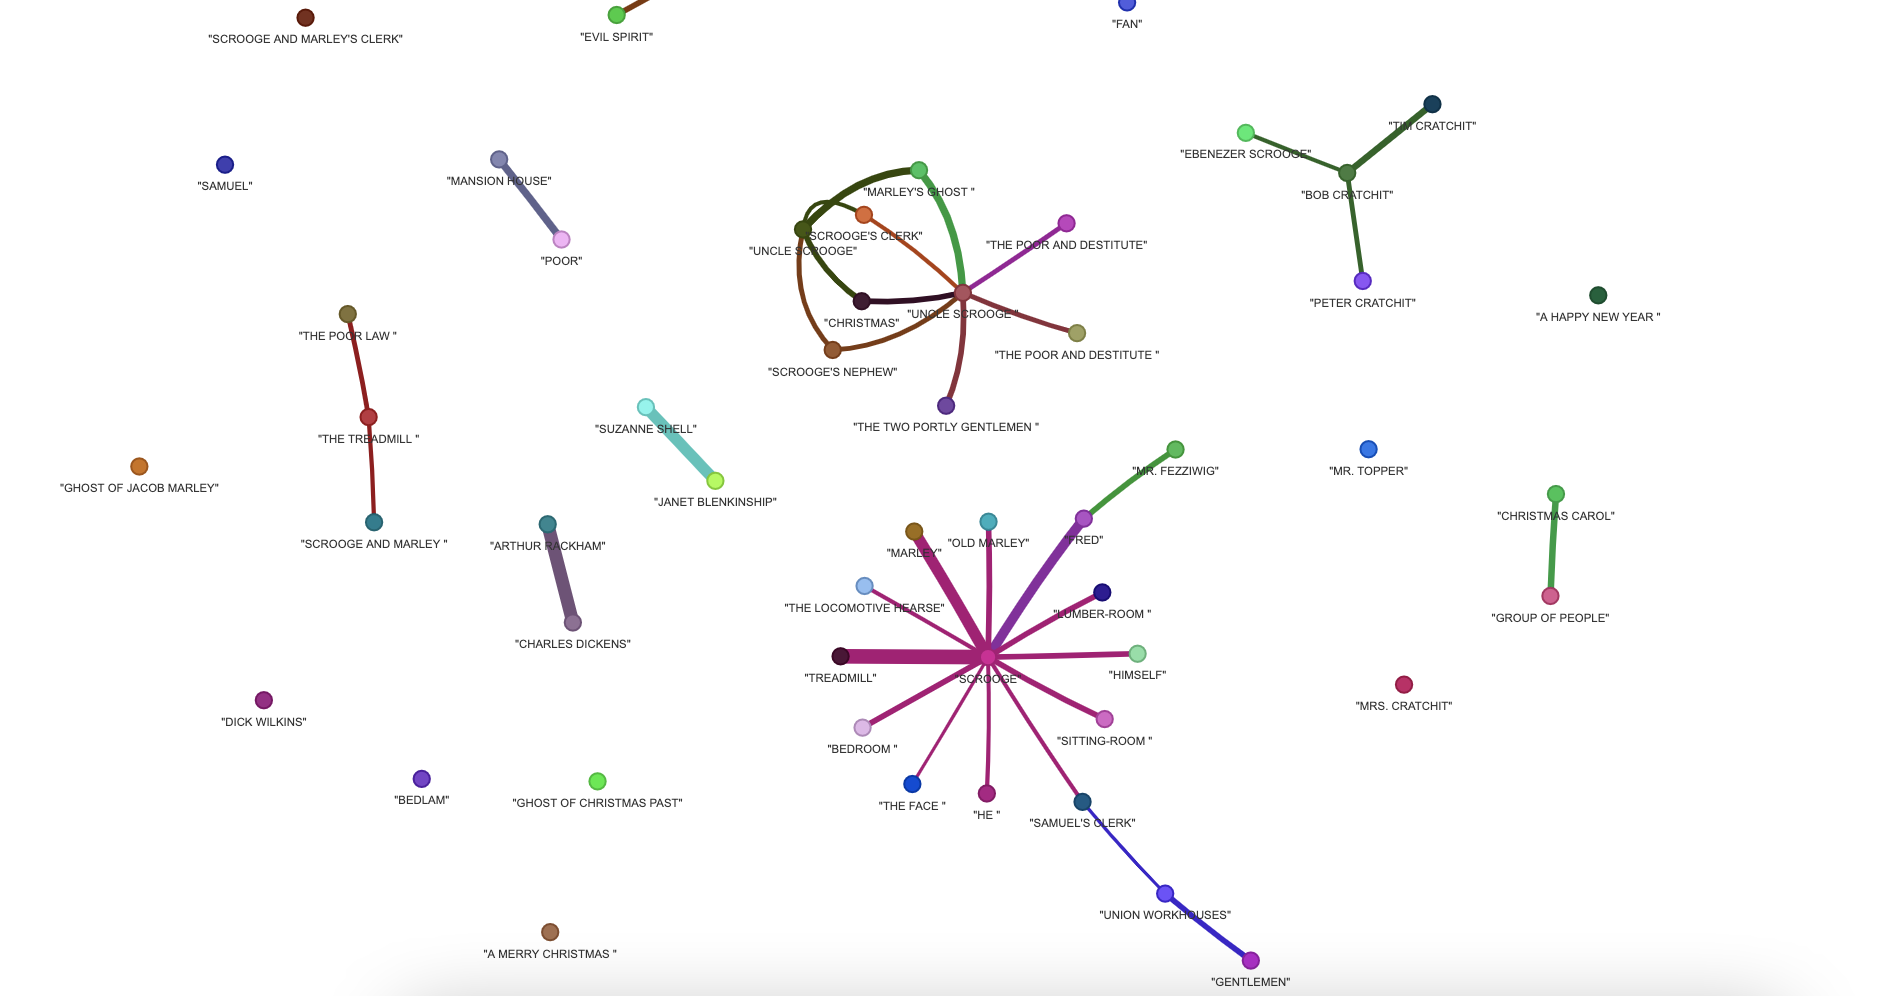

In [25]:
#@title Install Neo4j
%cd /content
!apt-get install openjdk-18-jdk-headless -qq > /dev/null
!java -version
!curl -O https://dist.neo4j.org/neo4j-community-5.21.2-unix.tar.gz
!tar -xf neo4j-community-5.21.2-unix.tar.gz

/content
openjdk version "18.0.2-ea" 2022-07-19
OpenJDK Runtime Environment (build 18.0.2-ea+9-Ubuntu-222.04)
OpenJDK 64-Bit Server VM (build 18.0.2-ea+9-Ubuntu-222.04, mixed mode, sharing)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  120M  100  120M    0     0  85.1M      0  0:00:01  0:00:01 --:--:-- 85.1M


In [26]:


fb.fabricate({
  "baseDir": "/content/LightRAG",
  "fabs": [
    {
        "srcFilename": "/content/neo4j-community-5.21.2/conf/neo4j.conf",
        "patches": [{
        "lineNum": 209,
        "fromText": '''#dbms.security.allow_csv_import_from_file_urls=true''',
        "toText":   '''#dbms.security.allow_csv_import_from_file_urls=true\ndbms.security.auth_enabled=false''',
        }]
    }
  ]
})

In [27]:
!cd neo4j-community-5.21.2 && ./bin/neo4j start
!cd neo4j-community-5.21.2 && ./bin/neo4j status

Directories in use:
home:         /content/neo4j-community-5.21.2
config:       /content/neo4j-community-5.21.2/conf
logs:         /content/neo4j-community-5.21.2/logs
plugins:      /content/neo4j-community-5.21.2/plugins
import:       /content/neo4j-community-5.21.2/import
data:         /content/neo4j-community-5.21.2/data
certificates: /content/neo4j-community-5.21.2/certificates
licenses:     /content/neo4j-community-5.21.2/licenses
run:          /content/neo4j-community-5.21.2/run
Starting Neo4j.
WARNING! You are using an unsupported Java runtime.
* Please use Java(TM) 17 or Java(TM) 21 to run Neo4j.
* Please see https://neo4j.com/docs/ for Neo4j installation instructions.
Started neo4j (pid:11382). It is available at http://localhost:7474
There may be a short delay until the server is ready.
Neo4j is running at pid 11382


In [28]:
!wget -Ocpolar-stable-linux-amd64.zip https://www.cpolar.com/static/downloads/releases/3.3.18/cpolar-stable-linux-amd64.zip?_gl=1*fmjrcv*_ga*ODE3OTg2MTMwLjE3MjE3ODk5MTY.*_ga_WF16DPKZZ1*MTcyMjA0MjU2My42LjEuMTcyMjA0MjU4My40MC4wLjA.
!unzip cpolar-stable-linux-amd64.zip
!chmod 777 cpolar
!rm -rf cpolar-stable-linux-amd64.zip
!./cpolar authtoken ...

--2024-10-24 02:02:39--  https://www.cpolar.com/static/downloads/releases/3.3.18/cpolar-stable-linux-amd64.zip?_gl=1*fmjrcv*_ga*ODE3OTg2MTMwLjE3MjE3ODk5MTY.*_ga_WF16DPKZZ1*MTcyMjA0MjU2My42LjEuMTcyMjA0MjU4My40MC4wLjA.
Resolving www.cpolar.com (www.cpolar.com)... 163.181.66.245, 163.181.66.243, 163.181.66.246, ...
Connecting to www.cpolar.com (www.cpolar.com)|163.181.66.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7423434 (7.1M) [application/zip]
Saving to: ‘cpolar-stable-linux-amd64.zip’

cpolar-stable-linux 100%[===================>]   7.08M  1.29MB/s    in 8.4s    

2024-10-24 02:02:48 (860 KB/s) - ‘cpolar-stable-linux-amd64.zip’ saved [7423434/7423434]

Archive:  cpolar-stable-linux-amd64.zip
  inflating: cpolar                  
Authtoken saved to configuration file: /root/.cpolar/cpolar.yml


In [29]:
!nohup ./cpolar http 7474 &

nohup: appending output to 'nohup.out'


In [30]:
!ps -ef | grep cpolar

root       11697       1  3 02:02 ?        00:00:00 cpolar: master procSHELL=/bin/bash
root       11710     275  0 02:02 ?        00:00:00 /bin/bash -c ps -ef | grep cpolar
root       11712   11710  0 02:02 ?        00:00:00 grep cpolar


In [32]:
!pip3 install -q neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.6/296.6 kB 5.8 MB/s eta 0:00:00


In [33]:
#@markdown <details>
#@markdown <summary> Graph visualization with Neo4j </summary>
#@markdown
#@markdown * The following code can be found in `examples/graph_visual_with_neo4j.py`
#@markdown
#@markdown ```python
#@markdown import os
#@markdown import json
#@markdown from lightrag.utils import xml_to_json
#@markdown from neo4j import GraphDatabase
#@markdown
#@markdown # Constants
#@markdown WORKING_DIR = "./dickens"
#@markdown BATCH_SIZE_NODES = 500
#@markdown BATCH_SIZE_EDGES = 100
#@markdown
#@markdown # Neo4j connection credentials
#@markdown NEO4J_URI = "bolt://localhost:7687"
#@markdown NEO4J_USERNAME = "neo4j"
#@markdown NEO4J_PASSWORD = "your_password"
#@markdown
#@markdown def convert_xml_to_json(xml_path, output_path):
#@markdown     """Converts XML file to JSON and saves the output."""
#@markdown     if not os.path.exists(xml_path):
#@markdown         print(f"Error: File not found - {xml_path}")
#@markdown         return None
#@markdown
#@markdown     json_data = xml_to_json(xml_path)
#@markdown     if json_data:
#@markdown         with open(output_path, 'w', encoding='utf-8') as f:
#@markdown             json.dump(json_data, f, ensure_ascii=False, indent=2)
#@markdown         print(f"JSON file created: {output_path}")
#@markdown         return json_data
#@markdown     else:
#@markdown         print("Failed to create JSON data")
#@markdown         return None
#@markdown
#@markdown def process_in_batches(tx, query, data, batch_size):
#@markdown     """Process data in batches and execute the given query."""
#@markdown     for i in range(0, len(data), batch_size):
#@markdown         batch = data[i:i + batch_size]
#@markdown         tx.run(query, {"nodes": batch} if "nodes" in query else {"edges": batch})
#@markdown
#@markdown def main():
#@markdown     # Paths
#@markdown     xml_file = os.path.join(WORKING_DIR, 'graph_chunk_entity_relation.graphml')
#@markdown     json_file = os.path.join(WORKING_DIR, 'graph_data.json')
#@markdown
#@markdown     # Convert XML to JSON
#@markdown     json_data = convert_xml_to_json(xml_file, json_file)
#@markdown     if json_data is None:
#@markdown         return
#@markdown
#@markdown     # Load nodes and edges
#@markdown     nodes = json_data.get('nodes', [])
#@markdown     edges = json_data.get('edges', [])
#@markdown
#@markdown     # Neo4j queries
#@markdown     create_nodes_query = """
#@markdown     UNWIND $nodes AS node
#@markdown     MERGE (e:Entity {id: node.id})
#@markdown     SET e.entity_type = node.entity_type,
#@markdown         e.description = node.description,
#@markdown         e.source_id = node.source_id,
#@markdown         e.displayName = node.id
#@markdown     REMOVE e:Entity
#@markdown     WITH e, node
#@markdown     CALL apoc.create.addLabels(e, [node.entity_type]) YIELD node AS labeledNode
#@markdown     RETURN count(*)
#@markdown     """
#@markdown
#@markdown     create_edges_query = """
#@markdown     UNWIND $edges AS edge
#@markdown     MATCH (source {id: edge.source})
#@markdown     MATCH (target {id: edge.target})
#@markdown     WITH source, target, edge,
#@markdown          CASE
#@markdown             WHEN edge.keywords CONTAINS 'lead' THEN 'lead'
#@markdown             WHEN edge.keywords CONTAINS 'participate' THEN 'participate'
#@markdown             WHEN edge.keywords CONTAINS 'uses' THEN 'uses'
#@markdown             WHEN edge.keywords CONTAINS 'located' THEN 'located'
#@markdown             WHEN edge.keywords CONTAINS 'occurs' THEN 'occurs'
#@markdown            ELSE REPLACE(SPLIT(edge.keywords, ',')[0], '\"', '')
#@markdown          END AS relType
#@markdown     CALL apoc.create.relationship(source, relType, {
#@markdown       weight: edge.weight,
#@markdown       description: edge.description,
#@markdown       keywords: edge.keywords,
#@markdown       source_id: edge.source_id
#@markdown     }, target) YIELD rel
#@markdown     RETURN count(*)
#@markdown     """
#@markdown
#@markdown     set_displayname_and_labels_query = """
#@markdown     MATCH (n)
#@markdown     SET n.displayName = n.id
#@markdown     WITH n
#@markdown     CALL apoc.create.setLabels(n, [n.entity_type]) YIELD node
#@markdown     RETURN count(*)
#@markdown     """
#@markdown
#@markdown     # Create a Neo4j driver
#@markdown     driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD))
#@markdown
#@markdown     try:
#@markdown         # Execute queries in batches
#@markdown         with driver.session() as session:
#@markdown             # Insert nodes in batches
#@markdown             session.execute_write(process_in_batches, create_nodes_query, nodes, BATCH_SIZE_NODES)
#@markdown
#@markdown             # Insert edges in batches
#@markdown             session.execute_write(process_in_batches, create_edges_query, edges, BATCH_SIZE_EDGES)
#@markdown
#@markdown             # Set displayName and labels
#@markdown             session.run(set_displayname_and_labels_query)
#@markdown
#@markdown     except Exception as e:
#@markdown         print(f"Error occurred: {e}")
#@markdown
#@markdown     finally:
#@markdown         driver.close()
#@markdown
#@markdown if __name__ == "__main__":
#@markdown     main()
#@markdown ```
#@markdown
#@markdown </details>


fb.fabricate({
  "baseDir": "/content/LightRAG",
  "fabs": [
    {
        "srcFilename": "/content/LightRAG/examples/graph_visual_with_neo4j.py",
        "patches": [{
        "lineNum": 14,
        "fromText": '''NEO4J_PASSWORD = "your_password"''',
        "toText":   '''NEO4J_PASSWORD = "neo4j"''',
        }]
    }
  ]
})

%cd /content/LightRAG
!python3 examples/graph_visual_with_neo4j.py

/content/LightRAG
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
Root element: {http://graphml.graphdrawing.org/xmlns}graphml
Root attributes: {'{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://graphml.graphdrawing.org/xmlns http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd'}
Found 69 nodes and 37 edges
JSON file created: ./dickens/graph_data.json
Error occurred: {code: Neo.ClientError.Procedure.ProcedureNotFound} {message: There is no procedure with the name `apoc.create.addLabels` registered for this database instance. Please ensure you've spelled the procedure name correctly and that the procedure is properly deployed.}


## Evaluation
### Dataset
The dataset used in LightRAG can be downloaded from [TommyChien/UltraDomain](https://huggingface.co/datasets/TommyChien/UltraDomain).

### Generate Query
LightRAG uses the following prompt to generate high-level queries, with the corresponding code in `example/generate_query.py`.

<details>
<summary> Prompt </summary>

```python
Given the following description of a dataset:

{description}

Please identify 5 potential users who would engage with this dataset. For each user, list 5 tasks they would perform with this dataset. Then, for each (user, task) combination, generate 5 questions that require a high-level understanding of the entire dataset.

Output the results in the following structure:
- User 1: [user description]
    - Task 1: [task description]
        - Question 1:
        - Question 2:
        - Question 3:
        - Question 4:
        - Question 5:
    - Task 2: [task description]
        ...
    - Task 5: [task description]
- User 2: [user description]
    ...
- User 5: [user description]
    ...
```
</details>

 ### Batch Eval
To evaluate the performance of two RAG systems on high-level queries, LightRAG uses the following prompt, with the specific code available in `example/batch_eval.py`.

<details>
<summary> Prompt </summary>

```python
---Role---
You are an expert tasked with evaluating two answers to the same question based on three criteria: **Comprehensiveness**, **Diversity**, and **Empowerment**.
---Goal---
You will evaluate two answers to the same question based on three criteria: **Comprehensiveness**, **Diversity**, and **Empowerment**.

- **Comprehensiveness**: How much detail does the answer provide to cover all aspects and details of the question?
- **Diversity**: How varied and rich is the answer in providing different perspectives and insights on the question?
- **Empowerment**: How well does the answer help the reader understand and make informed judgments about the topic?

For each criterion, choose the better answer (either Answer 1 or Answer 2) and explain why. Then, select an overall winner based on these three categories.

Here is the question:
{query}

Here are the two answers:

**Answer 1:**
{answer1}

**Answer 2:**
{answer2}

Evaluate both answers using the three criteria listed above and provide detailed explanations for each criterion.

Output your evaluation in the following JSON format:

{{
    "Comprehensiveness": {{
        "Winner": "[Answer 1 or Answer 2]",
        "Explanation": "[Provide explanation here]"
    }},
    "Empowerment": {{
        "Winner": "[Answer 1 or Answer 2]",
        "Explanation": "[Provide explanation here]"
    }},
    "Overall Winner": {{
        "Winner": "[Answer 1 or Answer 2]",
        "Explanation": "[Summarize why this answer is the overall winner based on the three criteria]"
    }}
}}
```
</details>



### Overall Performance Table
|                      | **Agriculture**             |                       | **CS**                    |                       | **Legal**                 |                       | **Mix**                   |                       |
|----------------------|-------------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|-----------------------|
|                      | NaiveRAG                | **LightRAG**           | NaiveRAG              | **LightRAG**           | NaiveRAG              | **LightRAG**           | NaiveRAG              | **LightRAG**           |
| **Comprehensiveness** | 32.69%                  | **67.31%**             | 35.44%                | **64.56%**             | 19.05%                | **80.95%**             | 36.36%                | **63.64%**             |
| **Diversity**         | 24.09%                  | **75.91%**             | 35.24%                | **64.76%**             | 10.98%                | **89.02%**             | 30.76%                | **69.24%**             |
| **Empowerment**       | 31.35%                  | **68.65%**             | 35.48%                | **64.52%**             | 17.59%                | **82.41%**             | 40.95%                | **59.05%**             |
| **Overall**           | 33.30%                  | **66.70%**             | 34.76%                | **65.24%**             | 17.46%                | **82.54%**             | 37.59%                | **62.40%**             |
|                      | RQ-RAG                  | **LightRAG**           | RQ-RAG                | **LightRAG**           | RQ-RAG                | **LightRAG**           | RQ-RAG                | **LightRAG**           |
| **Comprehensiveness** | 32.05%                  | **67.95%**             | 39.30%                | **60.70%**             | 18.57%                | **81.43%**             | 38.89%                | **61.11%**             |
| **Diversity**         | 29.44%                  | **70.56%**             | 38.71%                | **61.29%**             | 15.14%                | **84.86%**             | 28.50%                | **71.50%**             |
| **Empowerment**       | 32.51%                  | **67.49%**             | 37.52%                | **62.48%**             | 17.80%                | **82.20%**             | 43.96%                | **56.04%**             |
| **Overall**           | 33.29%                  | **66.71%**             | 39.03%                | **60.97%**             | 17.80%                | **82.20%**             | 39.61%                | **60.39%**             |
|                      | HyDE                    | **LightRAG**           | HyDE                  | **LightRAG**           | HyDE                  | **LightRAG**           | HyDE                  | **LightRAG**           |
| **Comprehensiveness** | 24.39%                  | **75.61%**             | 36.49%                | **63.51%**             | 27.68%                | **72.32%**             | 42.17%                | **57.83%**             |
| **Diversity**         | 24.96%                  | **75.34%**             | 37.41%                | **62.59%**             | 18.79%                | **81.21%**             | 30.88%                | **69.12%**             |
| **Empowerment**       | 24.89%                  | **75.11%**             | 34.99%                | **65.01%**             | 26.99%                | **73.01%**             | **45.61%**            | **54.39%**             |
| **Overall**           | 23.17%                  | **76.83%**             | 35.67%                | **64.33%**             | 27.68%                | **72.32%**             | 42.72%                | **57.28%**             |
|                      | GraphRAG                | **LightRAG**           | GraphRAG              | **LightRAG**           | GraphRAG              | **LightRAG**           | GraphRAG              | **LightRAG**           |
| **Comprehensiveness** | 45.56%                  | **54.44%**             | 45.98%                | **54.02%**             | 47.13%                | **52.87%**             | **51.86%**            | 48.14%                |
| **Diversity**         | 19.65%                  | **80.35%**             | 39.64%                | **60.36%**             | 25.55%                | **74.45%**             | 35.87%                | **64.13%**             |
| **Empowerment**       | 36.69%                  | **63.31%**             | 45.09%                | **54.91%**             | 42.81%                | **57.19%**             | **52.94%**            | 47.06%                |
| **Overall**           | 43.62%                  | **56.38%**             | 45.98%                | **54.02%**             | 45.70%                | **54.30%**             | **51.86%**            | 48.14%                |

## Reproduce
All the code can be found in the `./reproduce` directory.

### Step-0 Extract Unique Contexts
First, we need to extract unique contexts in the datasets.

<details>
<summary> Code </summary>

```python
def extract_unique_contexts(input_directory, output_directory):

    os.makedirs(output_directory, exist_ok=True)

    jsonl_files = glob.glob(os.path.join(input_directory, '*.jsonl'))
    print(f"Found {len(jsonl_files)} JSONL files.")

    for file_path in jsonl_files:
        filename = os.path.basename(file_path)
        name, ext = os.path.splitext(filename)
        output_filename = f"{name}_unique_contexts.json"
        output_path = os.path.join(output_directory, output_filename)

        unique_contexts_dict = {}

        print(f"Processing file: {filename}")

        try:
            with open(file_path, 'r', encoding='utf-8') as infile:
                for line_number, line in enumerate(infile, start=1):
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        json_obj = json.loads(line)
                        context = json_obj.get('context')
                        if context and context not in unique_contexts_dict:
                            unique_contexts_dict[context] = None
                    except json.JSONDecodeError as e:
                        print(f"JSON decoding error in file {filename} at line {line_number}: {e}")
        except FileNotFoundError:
            print(f"File not found: {filename}")
            continue
        except Exception as e:
            print(f"An error occurred while processing file {filename}: {e}")
            continue

        unique_contexts_list = list(unique_contexts_dict.keys())
        print(f"There are {len(unique_contexts_list)} unique `context` entries in the file {filename}.")

        try:
            with open(output_path, 'w', encoding='utf-8') as outfile:
                json.dump(unique_contexts_list, outfile, ensure_ascii=False, indent=4)
            print(f"Unique `context` entries have been saved to: {output_filename}")
        except Exception as e:
            print(f"An error occurred while saving to the file {output_filename}: {e}")

    print("All files have been processed.")

```
</details>

### Step-1 Insert Contexts
For the extracted contexts, we insert them into the LightRAG system.

<details>
<summary> Code </summary>

```python
def insert_text(rag, file_path):
    with open(file_path, mode='r') as f:
        unique_contexts = json.load(f)

    retries = 0
    max_retries = 3
    while retries < max_retries:
        try:
            rag.insert(unique_contexts)
            break
        except Exception as e:
            retries += 1
            print(f"Insertion failed, retrying ({retries}/{max_retries}), error: {e}")
            time.sleep(10)
    if retries == max_retries:
        print("Insertion failed after exceeding the maximum number of retries")
```
</details>

### Step-2 Generate Queries

We extract tokens from the first and the second half of each context in the dataset, then combine them as dataset descriptions to generate queries.

<details>
<summary> Code </summary>

```python
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

def get_summary(context, tot_tokens=2000):
    tokens = tokenizer.tokenize(context)
    half_tokens = tot_tokens // 2

    start_tokens = tokens[1000:1000 + half_tokens]
    end_tokens = tokens[-(1000 + half_tokens):1000]

    summary_tokens = start_tokens + end_tokens
    summary = tokenizer.convert_tokens_to_string(summary_tokens)

    return summary
```
</details>

### Step-3 Query
For the queries generated in Step-2, we will extract them and query LightRAG.

<details>
<summary> Code </summary>

```python
def extract_queries(file_path):
    with open(file_path, 'r') as f:
        data = f.read()

    data = data.replace('**', '')

    queries = re.findall(r'- Question \d+: (.+)', data)

    return queries
```
</details>

## Code Structure

```python
.
├── examples
│   ├── batch_eval.py
│   ├── graph_visual_with_html.py
│   ├── graph_visual_with_neo4j.py
│   ├── generate_query.py
│   ├── lightrag_azure_openai_demo.py
│   ├── lightrag_bedrock_demo.py
│   ├── lightrag_hf_demo.py
│   ├── lightrag_ollama_demo.py
│   ├── lightrag_openai_compatible_demo.py
│   ├── lightrag_openai_demo.py
│   ├── lightrag_siliconcloud_demo.py
│   └── vram_management_demo.py
├── lightrag
│   ├── __init__.py
│   ├── base.py
│   ├── lightrag.py
│   ├── llm.py
│   ├── operate.py
│   ├── prompt.py
│   ├── storage.py
│   └── utils.py
├── reproduce
│   ├── Step_0.py
│   ├── Step_1.py
│   ├── Step_2.py
│   └── Step_3.py
├── .gitignore
├── .pre-commit-config.yaml
├── LICENSE
├── README.md
├── requirements.txt
└── setup.py
```

## Star History

<a href="https://star-history.com/#HKUDS/LightRAG&Date">
 <picture>
   <source media="(prefers-color-scheme: dark)" srcset="https://api.star-history.com/svg?repos=HKUDS/LightRAG&type=Date&theme=dark" />
   <source media="(prefers-color-scheme: light)" srcset="https://api.star-history.com/svg?repos=HKUDS/LightRAG&type=Date" />
   <img alt="Star History Chart" src="https://api.star-history.com/svg?repos=HKUDS/LightRAG&type=Date" />
 </picture>
</a>

## Citation

```python
@article{guo2024lightrag,
title={LightRAG: Simple and Fast Retrieval-Augmented Generation},
author={Zirui Guo and Lianghao Xia and Yanhua Yu and Tu Ao and Chao Huang},
year={2024},
eprint={2410.05779},
archivePrefix={arXiv},
primaryClass={cs.IR}
}
```